# ClearMap2 parameter sweep on annotated volumes

The goal of this notebook is to perform a parameter sweep on a folder of tiff files that users have annotated and saved those annotations as RoiSet.zip files. If you have already turned these tiffs into stitched volumes, there's an option for that.

## Set up directories and imports

In [97]:
# imports 
import os,sys,json,glob,shutil
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tif
import pandas as pd
import seaborn as sns
from scipy.spatial import distance


In [98]:
path_to_cm2 = '/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe/ClearMap2'
src = '/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/cm2'
ann_folder = os.path.join(src,'202107_smartspim_anns')
sys.path.append(path_to_cm2)

## Define functions

In [99]:
def convert_tiff_to_npy(ann_folder,this_ann_folder):
    file_loc = os.path.join(ann_folder,this_ann_folder)
    imported_tiff = tif.imread(file_loc)
    np.save(file_loc[0:-4] + '.npy',imported_tiff)

In [100]:
def get_ann_vals_in_np(nn_folder,ann_file):
    ann_vals=[]
    if '.zip' in ann_file[-4:]:
        ann_file_formatted=ann_file[:-4]
    else:
        ann_file_formatted=ann_file
    these_anns = os.listdir(os.path.join(ann_folder,ann_file_formatted))
    for j in np.arange(0,len(these_anns)):
        z = int(these_anns[j][0:4])
        y = int(these_anns[j][5:9])
        x = int(these_anns[j][10:14])
        ann_vals.append([z,y,x])
    return ann_vals

In [101]:
def pairwise_distance_metrics_given_cdists(
        ground_truth, predicted, y, cutoff=10, verbose=True):
    """
    Function to calculate the pairwise distances
    between two lists of zyx points.

    Inputs:
    -------
    ground_truth, predicted: each iterable
    consisting of ndimensional coordinates.
    y: matrix of distances between all
    elements of ground truth and predicted

    Returns:
    -------
    paired: list of [ground_truth"s index
    (from input list), predicted"s index (from input list), distance]
    tp,fp,fn: statistics on true positives,
    false positives, and false negatives.
    """
    # only keep those distances that are below the cutoff!
    truth_indices, pred_indices = np.where(y <= cutoff)
    dists = zip(y[truth_indices, pred_indices], truth_indices, pred_indices)

    # sort by smallest dist
    dists = sorted(dists, key=lambda x: x[0])

    used_truth = set()
    used_pred = set()
    paired = []
    for (i, dist) in enumerate(dists):
        d = dist[0]
        if d > cutoff:
            # we have reached distances beyond the cutoff
            break
        truth_idx = dist[1]
        pred_idx = dist[2]
        if truth_idx not in used_truth and pred_idx not in used_pred:
            paired.append((truth_idx, pred_idx, d))
            used_truth.add(truth_idx)
            used_pred.add(pred_idx)
        if len(used_truth) == len(ground_truth) or len(used_pred) == len(predicted):
            # we have used up all the entries from the shorter list
            break

    tp = len(paired)
    fn = len(ground_truth) - len(paired)
    fp = len(predicted) - len(paired)
    if verbose:
        print("TP: {}, FP: {}, FN: {}".format(tp, fp, fn))
    # print(paired)

    if verbose:
       plt.hist([xx[2] for xx in paired], bins=np.max((int(len(paired)/500), 10)))
       plt.title("Histogram of distances - pixel or microns")

    return paired, tp, fp, fn

In [102]:
def filter_cells(source, thresholds):
  """Filter a array of detected cells according to the thresholds.
  
  Arguments
  ---------
  source : str, array or Source
    The source for the cell data.
  sink : str, array or Source
    The sink for the results.
  thresholds : dict
    Dictionary of the form {name : threshold} where name refers to the 
    column in the cell data and threshold can be None, a float 
    indicating a minimal threshold or a tuple (min,max) where min,max can be
    None or a minimal and maximal threshold value.
  
  Returns
  -------
  sink : str, array or Source
    The thresholded cell data.
  """
  
  ids = np.ones(source.shape[0], dtype=bool);
  for k,t in thresholds.items():
    if t:
      if not isinstance(t, (tuple, list)):
        t = (t, None);
      if t[0] is not None:
        ids = np.logical_and(ids, t[0] <= source[k])
      if t[1] is not None:
        ids = np.logical_and(ids, t[1] > source[k]);
  cells_filtered = source[ids];
  return cells_filtered


In [103]:
def pairwise_distance_metrics(ground_truth, predicted, cutoff=10, verbose=True):
    """
    Function to calculate the pairwise distances
    between two lists of zyx points.

    Inputs:
    -------
    ground_truth, predicted: each iterable consisting of
    ndimensional coordinates.

    Returns:
    -------
    paired: list of [ground_truth"s index (from input list),
    predicted"s index (from input list), distance]
    tp,fp,fn: statistics on true positives, false positives,
    and false negatives.
    """

    if verbose:
        print("\nCalculating pairwise distances...")
    y = distance.cdist(ground_truth, predicted, metric="euclidean")
    return pairwise_distance_metrics_given_cdists(
       ground_truth, predicted, y, cutoff, verbose)

## Prepare data for cm2

In [104]:
# if you need to make .npy files from tiffs:
listoftiffs = [f for f in os.listdir(ann_folder) if f.find('.tif') != -1]
for i in np.arange(0,len(listoftiffs)):
    convert_tiff_to_npy(ann_folder,listoftiffs[i])

/home/emilyjanedennis/anaconda3/envs/cm2/lib/python3.6/site-packages/tifffile/tifffile.py:3199: UserWarning: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
  warnings.warn(str(e))


In [105]:
listofanns = [f for f in os.listdir(ann_folder) if f.find('RoiSet') != -1]
listofnpys = [f for f in os.listdir(ann_folder) if f.find('.npy') != -1]

## Set up ClearMap2: imports and directories

In [63]:
import ClearMap.IO.Workspace as wsp
import ClearMap.IO.IO as io
import ClearMap.ImageProcessing.Experts.Cells as cells
from itertools import product

In [64]:
directory = ann_folder
ws = wsp.Workspace('CellMap', directory=directory);

## Define CM2 parameters to sweep over

In [65]:
# Here we list the parameter ranges to sweep over.
background_sizes = [5,7,9,11] # will make xy tuples like: (5,5), (7,7), (9,9)  
shape_threshold_sizes = [80,100,120,140,160,180,200]

In [66]:
# set up basic, shared cell_detection_parameters
cell_detection_parameter = cells.default_cell_detection_parameter.copy()
cell_detection_parameter['illumination'] = None
cell_detection_parameter['intensity_detection']['measure'] = ['source','background']

processing_parameter = cells.default_cell_detection_processing_parameter.copy()
processing_parameter.update(
    processes = 'serial',
    size_max = 100, #35,
    size_min = 30, #30,
    overlap  = 15, #10,
    verbose = True
    )

## CM2 Parameter sweep

# the following step takes awhile, please be patient!

In [67]:
for file in listofnpys:
    if file.find('bck') == -1 and file.find('filt')==-1:
        ws.update(stitched=file)
        ws.info()

        for background_size,shape_threshold_size in product(background_sizes,shape_threshold_sizes):
            this_cell_parameter_dict = cell_detection_parameter.copy()
            this_cell_parameter_dict['background_correction']['shape'] = (background_size,background_size)
            this_cell_parameter_dict['shape_detection']['threshold'] = shape_threshold_size
            postfix = f'raw_bck{background_size}_shpthresh{shape_threshold_size}'
            # actually detect cells:
            cells.detect_cells(ws.filename('stitched'),
                               ws.filename('stitched', postfix=postfix),
                               cell_detection_parameter=this_cell_parameter_dict,
                               processing_parameter=processing_parameter)

Workspace[CellMap]{/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/cm2/202107_smartspim_anns}
              raw: no file
 autofluorescence: no file
         stitched: j319_642_4000-4400_4100-4500_1790-1815.npy
           layout: no file
       background: no file
        resampled: no file
resampled_to_auto: no file
auto_to_reference: no file
            cells: no file
          density: no file

Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.019
Block 0/5

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.310
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.293
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.306
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.297
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.301
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.437
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.335
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.010
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.285
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.292
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.010
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.317
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.311
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.499
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.299
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.358
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.371
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.026
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: elapsed time: 0:00:00.000
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.294
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.330
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.308
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.293
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.453
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.315
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.309
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.313
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.415
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.018
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.331
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.026
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.374
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.357
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.335
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.018
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.314
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.522
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.018
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.295
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.329
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.031
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.302
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.294
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.017
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.298
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.373
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.297
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.291
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.029
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.310
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: elapsed time: 0:00:00.000
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.338
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.314
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.560
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.022
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.328
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.035
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.319
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.315
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.312
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.321
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.332
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.341
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.036
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.311
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.586
Workspace[CellMap]{/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/cm2/202107_smartspim_anns}
              raw: no file
 autofluorescence: no file
         stitched: e143_6200-6600_3800-4200_2185-2210.npy
           layout: no file
       background: no file
        resampled: no file
resampled_to_auto: no file
auto_to_reference: no file
            cells: no file
          density: no file

Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.304
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.354
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.300
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.021
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.308
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.016
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.295
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.287
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.307
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.013
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.286
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.463
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.010
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.292
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.309
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.303
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.388
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.299
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.312
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.027
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.297
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.016
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.293
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.315
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.305
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.325
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.026
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.339
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.609
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.296
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.297
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.316
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.313
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.302
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.333
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.314
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.017
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.295
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.465
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.327
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.028
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.341
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.314
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.298
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.017
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.324
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.461
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.029
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.301
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.317
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.319
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.305
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.300
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.419
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.022
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.298
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.022
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.296
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.296
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.305
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.297
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.297
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.303
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.297
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.454
Workspace[CellMap]{/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/cm2/202107_smartspim_anns}
              raw: no file
 autofluorescence: no file
         stitched: j317-488_040440_5990-6390_2820-3220.npy
           layout: no file
       background: no file
        resampled: no file
resampled_to_auto: no file
auto_to_reference: no file
            cells: no file
          density: no file

Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.379
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.007
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.329
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.016
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.322
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.007
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.329
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.007
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.353
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.605
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.007
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.331
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.007
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.289
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.007
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.282
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.007
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.270
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.007
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.310
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.007
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.279
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.308
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.016
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.010
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: elapsed time: 0:00:00.000
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.343
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.010
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.355
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.654
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.019
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.321
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.010
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.285
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.010
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.312
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.010
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.283
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.010
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.295
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.309
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.010
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.297
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.278
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.010
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.281
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.023
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: elapsed time: 0:00:00.000
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.370
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.389
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.873
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.357
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.022
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.293
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.025
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.332
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.461
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.289
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.272
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.012
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.286
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.317
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.018
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.301
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.026
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(1

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.452
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 4

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.021
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: elapsed time: 0:00:00.000
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: elapsed time: 0:00:00.000
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)

Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.898
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: DoG filter: sigma2: None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.358
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.323
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.365
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.304
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.286
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.298
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (19, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.277
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(19, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (19, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.305
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.328
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.431
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.289
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.021
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.287
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.293
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.304
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.297
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.392
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.289
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.301
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.289
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.304
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.309
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.510
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.335
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.318
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.300
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.298
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.298
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.419
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.309
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.028
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.312
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.287
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.396
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.023
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.297
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.302
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.312
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.367
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.321
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.299
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.301
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.017
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.296
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.374
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.337
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.304
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.314
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.306
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.017
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.300
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.455
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.024
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.292
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: elapsed time: 0:00:00.000
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: elapsed time: 0:00:00.000
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.319
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.322
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.465
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.028
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.302
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.035
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.297
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.296
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.295
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.303
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.033
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.296
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.293
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.035
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.301
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.386
Workspace[CellMap]{/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/cm2/202107_smartspim_anns}
              raw: no file
 autofluorescence: no file
         stitched: a253_5460_5170_19800-20280.npy
           layout: no file
       background: no file
        resampled: no file
resampled_to_auto: no file
auto_to_reference: no file
            cells: no file
          density: no file

Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.318
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.024
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.283
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.284
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.321
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.310
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.020
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.289
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.375
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.282
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.010
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.283
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.309
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.283
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.010
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.319
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.384
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.291
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.310
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.291
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.314
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.028
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.297
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.435
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.027
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.308
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.313
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.306
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.495
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.301
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.326
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.300
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.466
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.303
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.018
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.312
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.302
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.290
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.030
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.292
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.392
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.289
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.290
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.294
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.353
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.018
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.289
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.316
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.296
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.320
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.038
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.326
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.565
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.022
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.312
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.022
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.345
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.333
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.041
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.297
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.294
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.391
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.022
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.294
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.022
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.294
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.294
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.373
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.034
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.293
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.022
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: elapsed time: 0:00:00.000
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.311
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.388
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.010
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.288
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.020
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.284
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.020
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.301
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.301
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.285
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.310
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.010
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.298
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.021
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.283
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.010
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.284
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.020
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.305
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.293
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.397
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.309
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.292
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.298
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.416
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.027
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: elapsed time: 0:00:00.000
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.288
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.028
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.290
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.028
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.290
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.301
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.289
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.335
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.015
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.315
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.325
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.351
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.615
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.323
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.305
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.318
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.339
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.023
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.300
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.506
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.304
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.301
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.301
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.417
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.297
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.330
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.366
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.323
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.491
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.028
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma2: None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.307
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.301
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.304
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.300
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.306
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.313
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.534
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.032
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.330
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.022
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.316
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.306
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.020
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.316
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.287
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.010
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.283
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:00.288
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: elapsed time: 0:00:00.311
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.394
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.287
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.283
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.282
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.020
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:00.286
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.021
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.292
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.315
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:00.317
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.286
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.029
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.289
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:00.322
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: elapsed time: 0:00:00.293
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.362
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.016
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.320
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.301
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.029
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: elapsed time: 0:00:00.000
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.314
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.026
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.324
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.018
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.293
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.018
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:00.307
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.017
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: elapsed time: 0:00:00.309
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.449
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.030
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.290
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.018
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.307
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.029
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.289
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:00.301
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.030
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: elapsed time: 0:00:00.288
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.403
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.329
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.018
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.312
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.018
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.333
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:00.321
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.023
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: elapsed time: 0:00:00.317
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.506
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.023
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.315
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.022
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.352
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.024
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.302
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:00.302
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.023
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: elapsed time: 0:00:00.299
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.023
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: elapsed time: 0:00:00.297
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.023
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,77:169)]: elapsed time: 0:00:00.316
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.023
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,308:400)]: elapsed time: 0:00:00.297
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.405
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.022
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,154:246)]: elapsed time: 0:00:00.297
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.038
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@(25, 402, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 402, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.320
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.018
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.290
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.287
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.289
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.352
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.292
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.295
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.011
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.298
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (5, 5)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.011
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.299
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (5, 5)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.011
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.297
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (5, 5)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.010
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.290
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.419
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (5, 5)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.011
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.293
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (5, 5)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.011
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.307
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.298
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.293
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.290
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.015
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.290
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.015
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.288
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.295
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.351
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (7, 7)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.019
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.287
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (7, 7)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.015
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.288
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (7, 7)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.028
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.288
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (7, 7)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.024
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.311
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (7, 7)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.015
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.315
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.411
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.302
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.303
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.292
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.017
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.292
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.358
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.313
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.299
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (9, 9)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.028
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.288
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (9, 9)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.017
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.291
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (9, 9)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.017
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.291
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.358
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (9, 9)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.017
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.290
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (9, 9)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.017
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(2

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.318
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.354
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.526
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.022
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.301
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.022
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.301
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.324
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.022
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.307
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.022
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.322
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.589
Processing 5 blocks with function 'detect_cells_block'.
Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal shape: (11, 11)
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal form : Disk
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Background removal save : False
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: Illumination correction: elapsed time: 0:00:00.022
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: shape : None
Block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: DoG filter: sigma : None
Block 0/5<(0, 0, 0)/(1, 1, 5)>

Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: elapsed time: 0:00:00.342
Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal shape: (11, 11)
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal form : Disk
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Background removal save : False
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: Illumination correction: elapsed time: 0:00:00.035
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: shape : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma : None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: DoG filter: sigma2: None
Block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@

Processing block 0/5<(0, 0, 0)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,0:92)]: elapsed time: 0:00:00.333
Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal shape: (11, 11)
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal form : Disk
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Background removal save : False
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: Illumination correction: elapsed time: 0:00:00.022
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: shape : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma : None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: DoG filter: sigma2: None
Block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 4

Processing block 3/5<(0, 0, 3)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,231:323)]: elapsed time: 0:00:00.326
Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal shape: (11, 11)
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal form : Disk
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Background removal save : False
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: Illumination correction: elapsed time: 0:00:00.023
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: shape : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma : None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: DoG filter: sigma2: None
Block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@

Processing block 1/5<(0, 0, 1)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,77:169)]: elapsed time: 0:00:00.312
Processing block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal shape: (11, 11)
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal form : Disk
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Background removal save : False
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: Illumination correction: elapsed time: 0:00:00.035
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: shape : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma : None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,154:246)]: DoG filter: sigma2: None
Block 2/5<(0, 0, 2)/(1, 1, 5)> (25, 400, 92)@(

Processing block 4/5<(0, 0, 4)/(1, 1, 5)> (25, 400, 92)@(25, 400, 400)[(:,:,308:400)]: elapsed time: 0:00:00.297
Processed 5 blocks with function 'detect_cells_block': elapsed time: 0:00:02.501


## Calculate fp, fn, precision for each volume, save as data frame

In [68]:
listofnpys = [f for f in os.listdir(ann_folder) if f.find('.npy') != -1]
#listofnpys

# the following step takes awhile, please be patient!

In [69]:
list_of_vals = []
filt_srcs = [3]
filt_tup_starts = [5]
filt_tup_ends = [50,100,200,300,400]
all_tups = []
for i in np.arange(0,len(filt_tup_starts)):
    for j in np.arange(0,len(filt_tup_ends)):
        all_tups.append((filt_tup_starts[i],filt_tup_ends[j]))

chval = 'shpthresh'

for i in np.arange(0,len(listofnpys)):
    base_filename = listofnpys[i][0:-4]
    print(base_filename)
    if base_filename.find(chval) != -1:
        sweep_list = [f for f in os.listdir(ann_folder) if np.all(f.find('shpthresh') != -1 and f.find(base_filename) != -1)]
        test=base_filename.split('_raw')[0]
        print(test)
        ann_file = [f for f in listofanns if f.find(test) != -1][0]
        ann_vals = get_ann_vals_in_np(ann_folder, ann_file)
        for j in np.arange(0,len(sweep_list)):
            print('{} of {}'.format(j,len(sweep_list)))
            for k in filt_srcs:
                sweep_cells = np.load(os.path.join(ann_folder,sweep_list[j]))
                for ll in np.arange(0,len(all_tups)):
                    filt_vals = all_tups[ll]
                    filt_params = str('{}_{}_{}'.format(k,filt_vals[0],filt_vals[1]))
                    thresholds = {'source' : k,'size'   : filt_vals}
                    filetosave= os.path.join(ann_folder,"{}_{}_filtered.npy".format(sweep_list[j][:-4],filt_params))
                    cells.filter_cells(source = sweep_cells,
                                        sink = filetosave,
                                        thresholds=thresholds)
                    
                    filtered_cells = pd.DataFrame(np.load(filetosave))
                    paired, tp, fp, fn = pairwise_distance_metrics(ann_vals,filtered_cells[['x','y','z']],cutoff=30,verbose=False)
                    if tp+fp > 0:
                        precision = tp/(tp+fp)
                        recall = tp/(tp+fn)
                        try: 
                            f1 = 2*((precision*recall)/(precision+recall)) 
                        except: f1=0
                    else:
                        precision = 0
                        recall = 0
                        f1=0
                    list_of_vals.append([base_filename[0:12],sweep_list[j][-19:-17],sweep_list[j][-7:-4],filt_params,tp,fp,fn,precision,recall,f1])
pd_to_save = pd.DataFrame(list_of_vals,columns=['all','bck','shpthresh','filt_params','tp','fp','fn','precision','recall','f1'])
save_name = os.path.join(ann_folder,'ALL_withfilt_{}_sweep_RESULTS.csv'.format(chval))
pd_to_save.to_csv(save_name)
pd_642_orig=pd_to_save

a253_5710-6110_3740-4140_19800-20280_raw_bck7_shpthresh120
a253_5710-6110_3740-4140_19800-20280
0 of 1
a253_5710-6110_3740-4140_19800-20280_raw_bck7_shpthresh140
a253_5710-6110_3740-4140_19800-20280
0 of 1
a253_5710-6110_3740-4140_19800-20280_raw_bck5_shpthresh200
a253_5710-6110_3740-4140_19800-20280
0 of 1
j319_642_2300-2700_3500-3900_1990-2015_raw_bck7_shpthresh80
j319_642_2300-2700_3500-3900_1990-2015
0 of 1
j319_642_4000-4400_4100-4500_1790-1815_raw_bck9_shpthresh80
j319_642_4000-4400_4100-4500_1790-1815
0 of 1
a253_5460_5170_19800-20280_raw_bck11_shpthresh100
a253_5460_5170_19800-20280
0 of 1
e143_6200-6600_3800-4200_2185-2210_raw_bck11_shpthresh100
e143_6200-6600_3800-4200_2185-2210
0 of 1
j319_642_4000-4400_4100-4500_1790-1815_raw_bck11_shpthresh120
j319_642_4000-4400_4100-4500_1790-1815
0 of 1
j319_642_4000-4400_4100-4500_1790-1815
a253_5710-6110_3740-4140_19800-20280_raw_bck7_shpthresh180
a253_5710-6110_3740-4140_19800-20280
0 of 1
j319_642_4000-4400_4100-4500_1790-1815_raw_bc

j317-488_040440_5990-6390_2820-3220_raw_bck5_shpthresh200
j317-488_040440_5990-6390_2820-3220
0 of 1
j316_488_2200-2600_2000-2400_975-1000_raw_bck9_shpthresh180
j316_488_2200-2600_2000-2400_975-1000
0 of 1
e143_6200-6600_3800-4200_2185-2210_raw_bck9_shpthresh160
e143_6200-6600_3800-4200_2185-2210
0 of 1
a253_5710-6110_3740-4140_19800-20280_raw_bck11_shpthresh200
a253_5710-6110_3740-4140_19800-20280
0 of 1
e143_6200-6600_3800-4200_2185-2210_raw_bck9_shpthresh120
e143_6200-6600_3800-4200_2185-2210
0 of 1
a253_5710-6110_3740-4140_19800-20280_raw_bck9_shpthresh180
a253_5710-6110_3740-4140_19800-20280
0 of 1
e143_6200-6600_3800-4200_2185-2210_raw_bck5_shpthresh160
e143_6200-6600_3800-4200_2185-2210
0 of 1
j317-488_040440_5990-6390_2820-3220_raw_bck5_shpthresh160
j317-488_040440_5990-6390_2820-3220
0 of 1
a253_5710-6110_3740-4140_19800-20280_raw_bck7_shpthresh200
a253_5710-6110_3740-4140_19800-20280
0 of 1
j319_642_2300-2700_3500-3900_1990-2015_raw_bck11_shpthresh140
j319_642_2300-2700_3500-

a253_5460_5170_19800-20280
0 of 1
j317-488_040440_5990-6390_2820-3220_raw_bck9_shpthresh160
j317-488_040440_5990-6390_2820-3220
0 of 1
e143_6200-6600_3800-4200_2185-2210_raw_bck7_shpthresh140
e143_6200-6600_3800-4200_2185-2210
0 of 1
j316_488_2200-2600_2000-2400_975-1000_raw_bck11_shpthresh140
j316_488_2200-2600_2000-2400_975-1000
0 of 1
a253_5710-6110_3740-4140_19800-20280_raw_bck5_shpthresh140
a253_5710-6110_3740-4140_19800-20280
0 of 1
j319_642_2300-2700_3500-3900_1990-2015_raw_bck9_shpthresh80
j319_642_2300-2700_3500-3900_1990-2015
0 of 1
j316_488_2200-2600_2000-2400_975-1000_raw_bck11_shpthresh180
j316_488_2200-2600_2000-2400_975-1000
0 of 1
a253_5460_5170_19800-20280_raw_bck5_shpthresh120
a253_5460_5170_19800-20280
0 of 1
a253_3990_2590_19800-20280
j319_642_4000-4400_4100-4500_1790-1815_raw_bck11_shpthresh160
j319_642_4000-4400_4100-4500_1790-1815
0 of 1
a253_5460_5170_19800-20280_raw_bck5_shpthresh180
a253_5460_5170_19800-20280
0 of 1
a253_3990_2590_19800-20280_raw_bck7_shpthres

In [106]:
pd_642_orig = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/cm2/202107_smartspim_anns/ALL_withfilt_shpthresh_sweep_RESULTS.csv')

In [107]:
pd_642 = pd_642_orig.copy()
pd_642['shpthresh']=pd_642['shpthresh'].astype('int')
pd_642[pd_642['f1']>0.1]
#pd_642['min_size']=pd_642['min_size'].astype('int')
pd_642
#pd_642 = pd_642[pd_642['shpthresh'] <160]
#pd_642 = pd_642[pd_642['shpthresh'] >120]
#pd_642 = pd_642[pd_642['bck']=='13']
#pd_642=pd_642[pd_642['min_size']<12]
#pd_642=pd_642[pd_642['min_size']>5]

,Unnamed: 0,all,bck,shpthresh,filt_params,tp,fp,fn,precision,recall,f1
0,0,a253_5710-61,k7,120,3_5_50,668,1202,0,0.357219,1.000000,0.526399
1,1,a253_5710-61,k7,120,3_5_100,668,1326,0,0.335005,1.000000,0.501878
2,2,a253_5710-61,k7,120,3_5_200,668,1354,0,0.330366,1.000000,0.496654
3,3,a253_5710-61,k7,120,3_5_300,668,1360,0,0.329389,1.000000,0.495549
4,4,a253_5710-61,k7,120,3_5_400,668,1361,0,0.329226,1.000000,0.495365
...,...,...,...,...,...,...,...,...,...,...,...
4475,4475,e143_6200-66,11,140,3_20_50,83,66,24,0.557047,0.775701,0.648438
4476,4476,e143_6200-66,11,140,3_20_100,95,90,12,0.513514,0.887850,0.650685
4477,4477,e143_6200-66,11,140,3_20_200,99,93,8,0.515625,0.925234,0.662207
4478,4478,e143_6200-66,11,140,3_20_300,100,93,7,0.518135,0.934579,0.666667


In [230]:
print(len(pd_642))
pd_642 = pd_642[pd_642['recall']>0.3]
pd_642 = pd_642[pd_642['precision']>0.6]
print(len(pd_642))

1890
966


In [179]:
good_filts = np.unique(pd_642['filt_params'])
for name in np.unique(pd_642['all']):
    print(name)
    jt = pd_642[pd_642['all']==name]
    good_filts = np.intersect1d(good_filts,np.unique(jt['filt_params']))
print(good_filts)

a253_5460_51
a253_5710-61
e143_6200-66
j316_488_220
j319_642_230
j319_642_400
['3_10_100' '3_10_150' '3_10_200' '3_10_250' '3_10_300' '3_10_400'
 '3_10_50' '3_6_100' '3_6_150' '3_6_200' '3_6_250' '3_6_300' '3_6_400'
 '3_6_50' '3_8_100' '3_8_150' '3_8_200' '3_8_250' '3_8_300' '3_8_400'
 '3_8_50']


In [108]:
pd_filt = pd_642.copy()
for val in np.unique(pd_642['filt_params']):
    if val not in good_filts:
        pd_filt = pd_filt[pd_filt['filt_params']!=val]

NameError: name 'good_filts' is not defined

In [109]:
pd_filt = pd_642.copy()
#pd_filt = pd_642[pd_642['shpthresh']>120]
pd_filt = pd_filt[pd_filt['bck']!='ck']
pd_filt = pd_filt[pd_filt['bck']!='k1']
pd_filt = pd_filt[pd_filt['all']!='j317-488_040']
pd_filt = pd_filt[pd_filt['shpthresh']<160]
#pd_filt = pd_filt[pd_filt['filt_params']=='3_6_200']


In [ ]:
df[['']]

In [96]:
df.head()

NameError: name 'df' is not defined

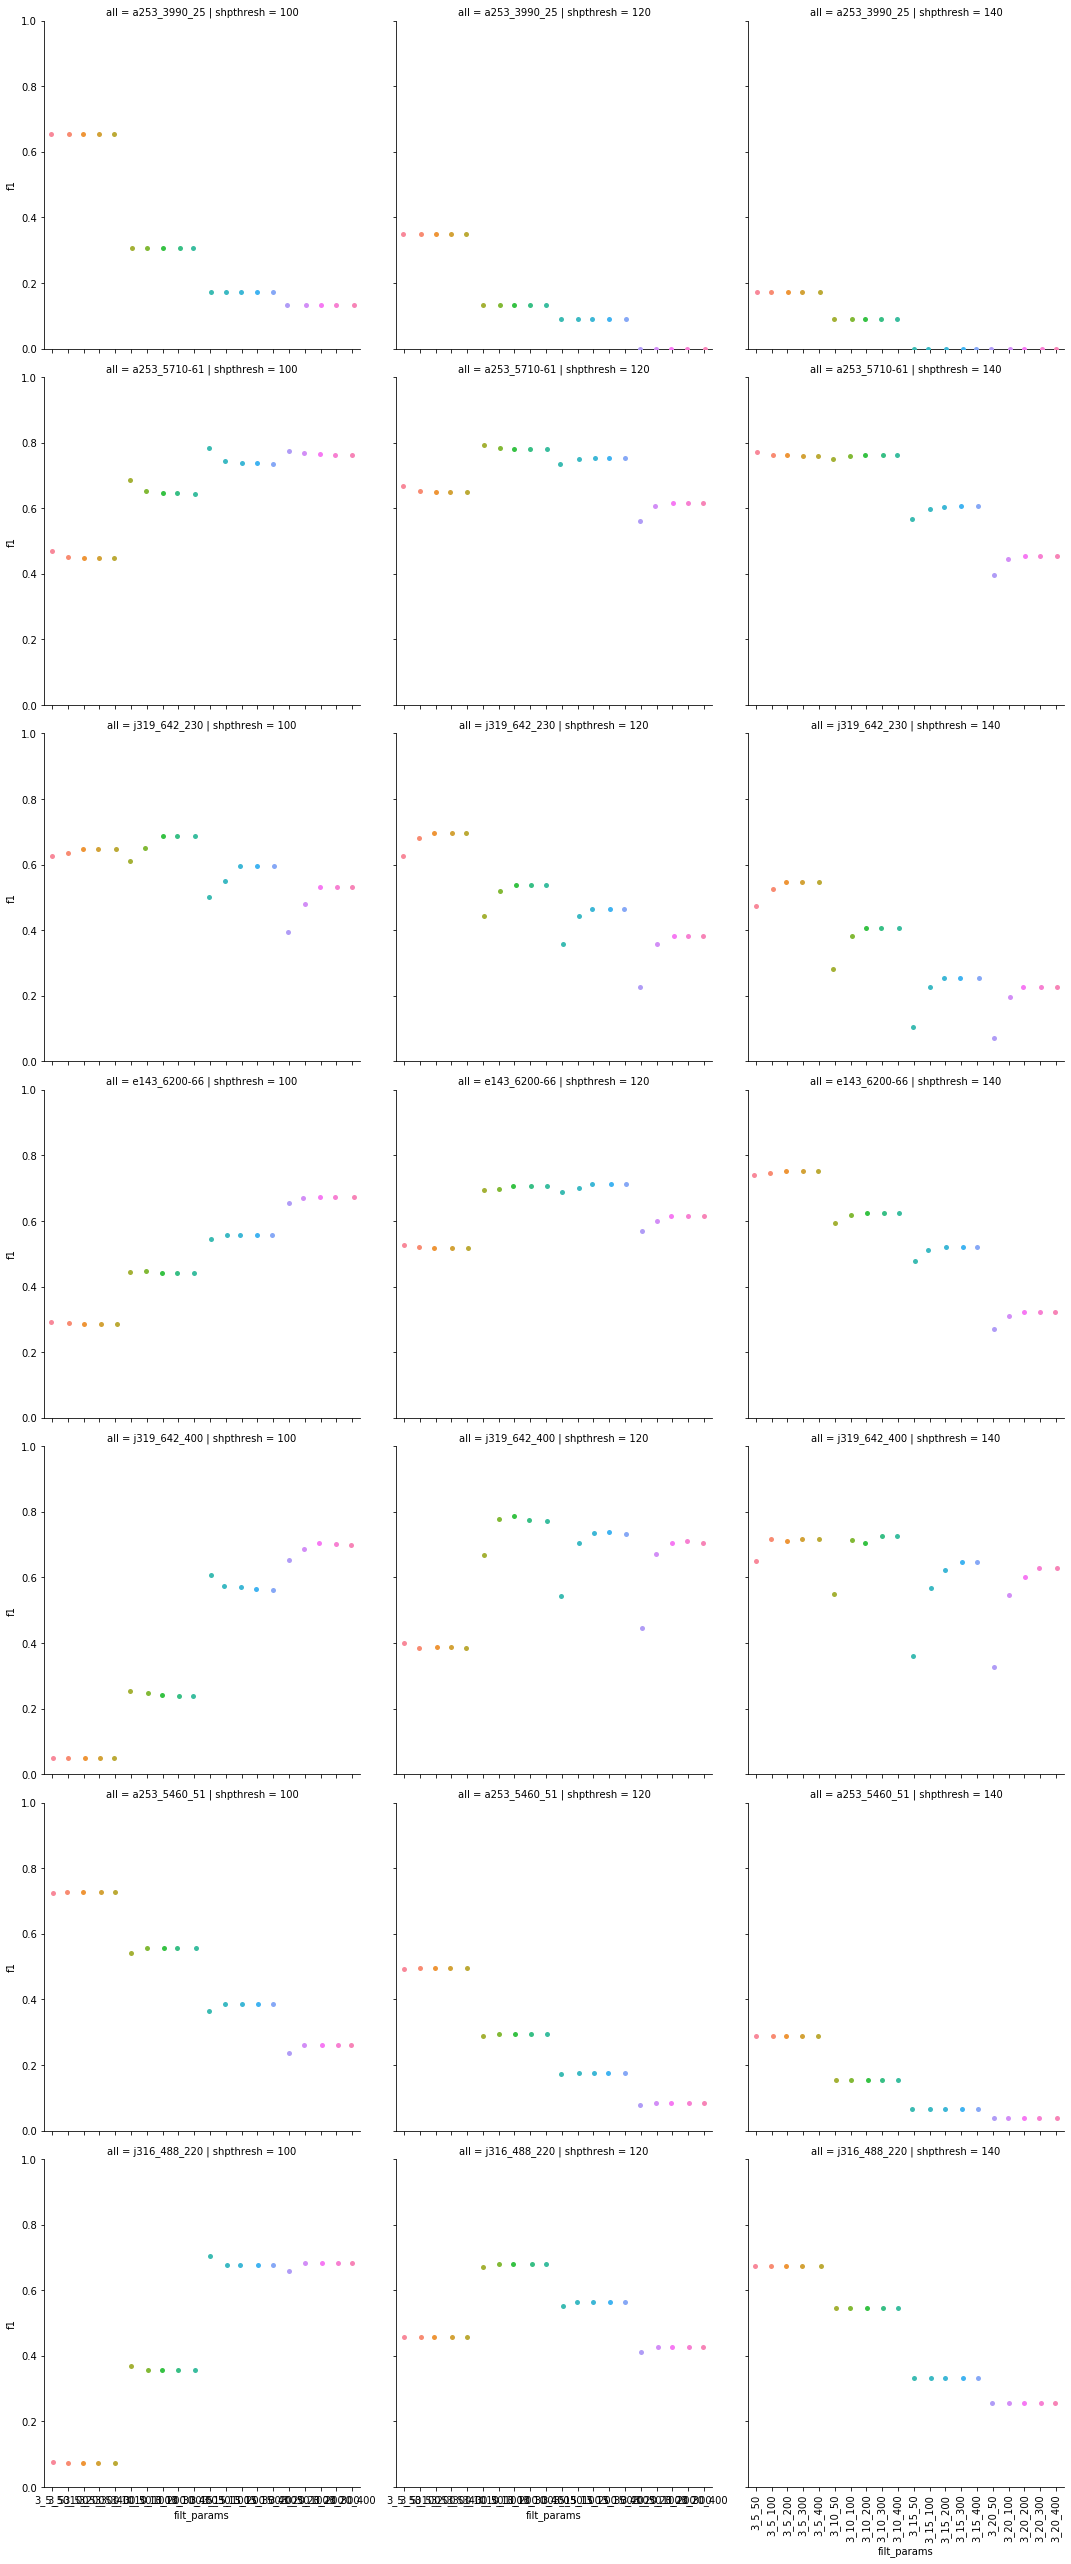

In [95]:
sns.catplot(data = pd_filt[pd_filt['bck']=='k5'],x='filt_params',y='f1',col='shpthresh',row = 'all')
plt.xticks(rotation=90)
plt.ylim([0,1])

plt.show()

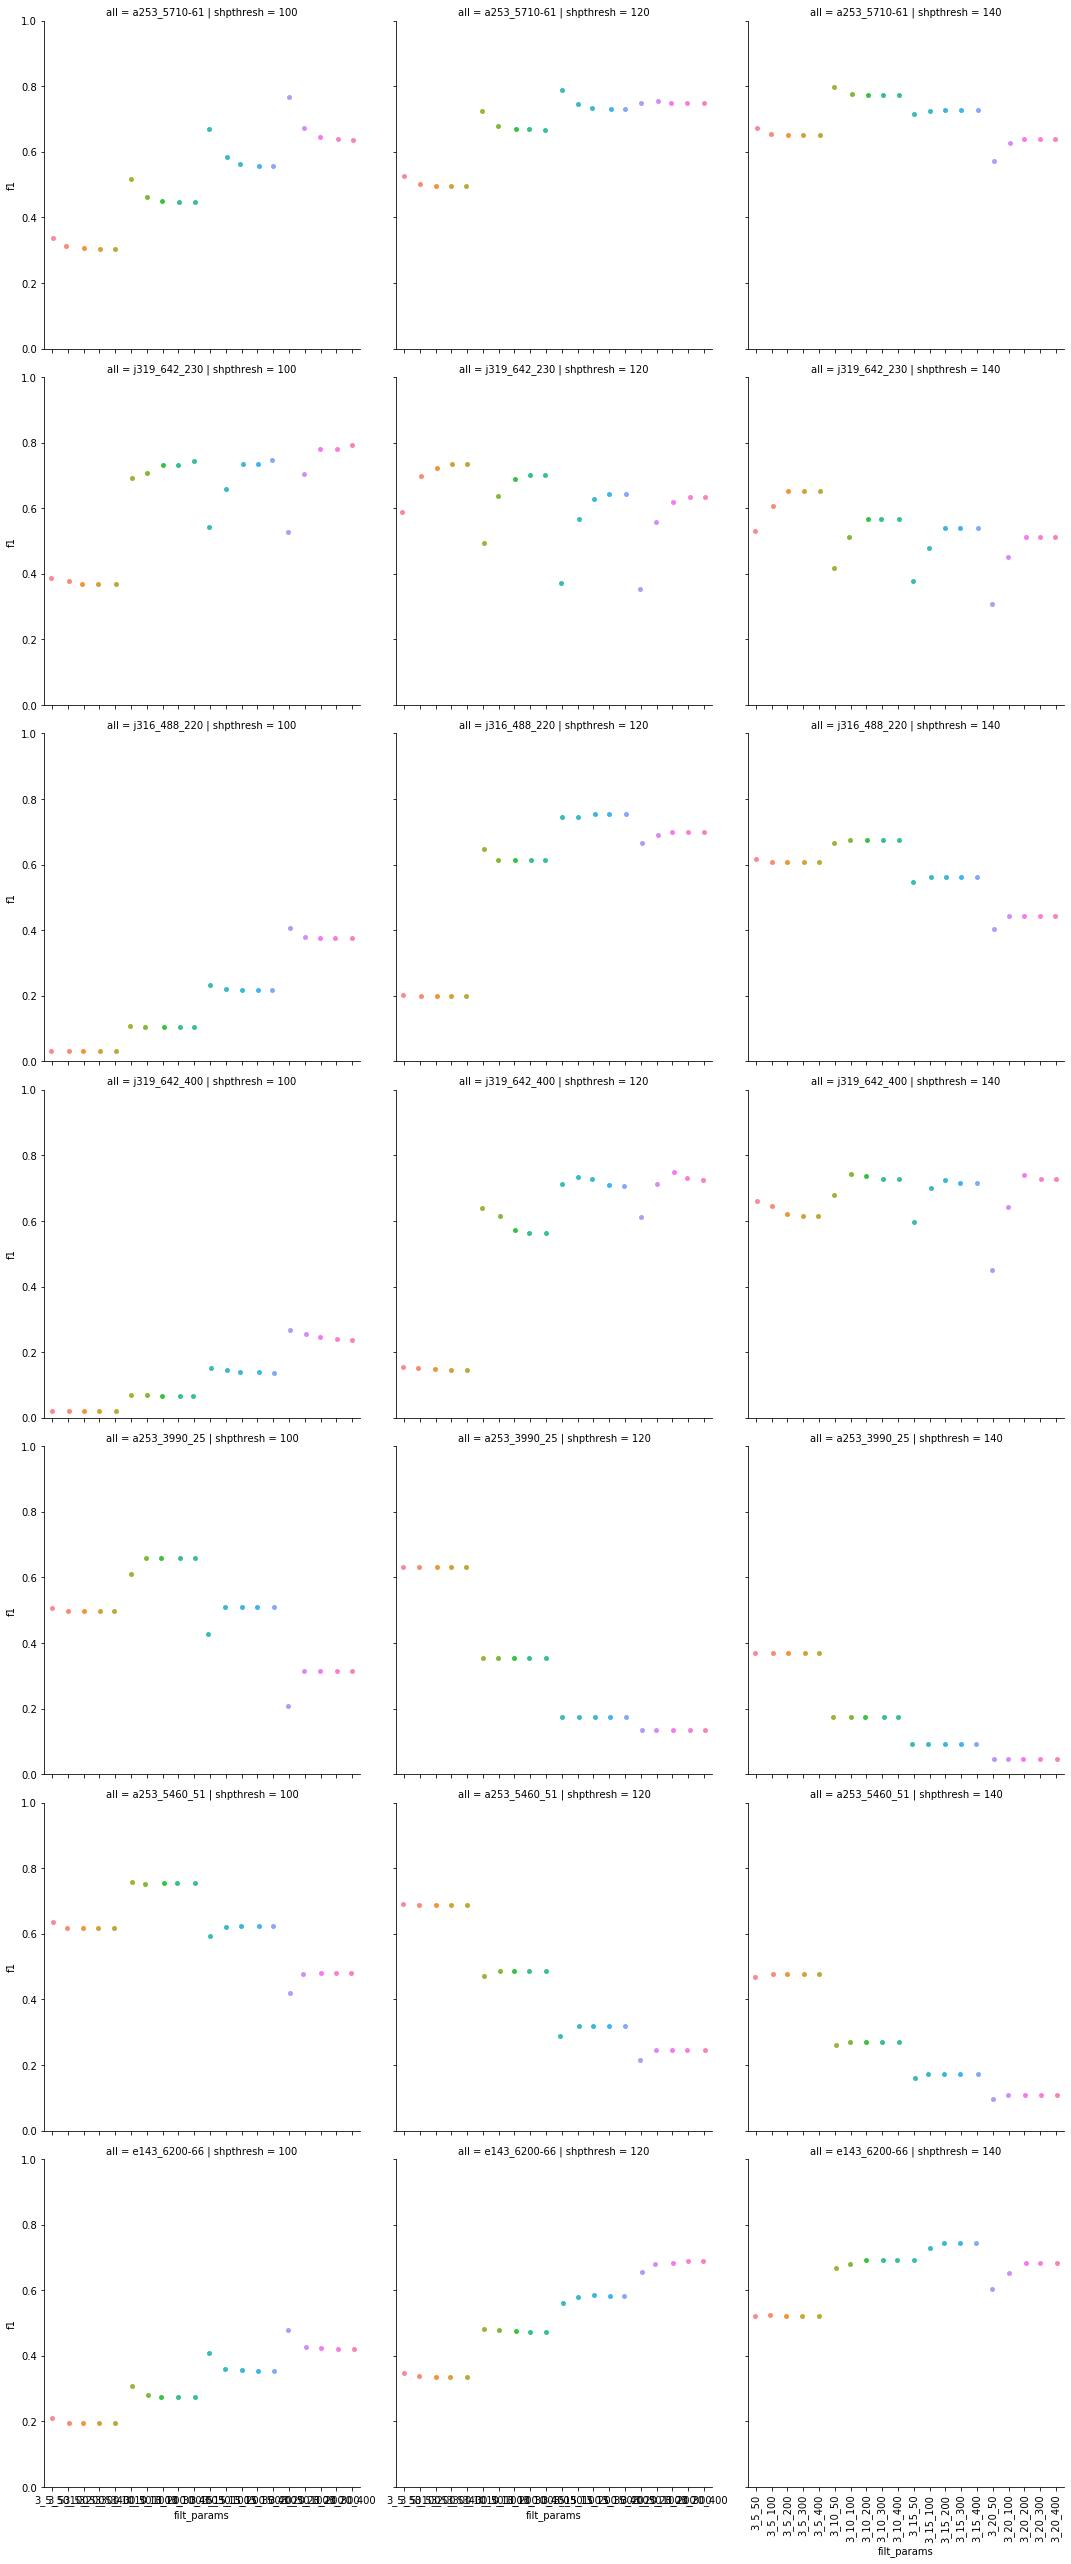

In [94]:
sns.catplot(data = pd_filt[pd_filt['bck']=='k7'],x='filt_params',y='f1',col='shpthresh',row = 'all')
plt.xticks(rotation=90)
plt.ylim([0,1])

plt.show()

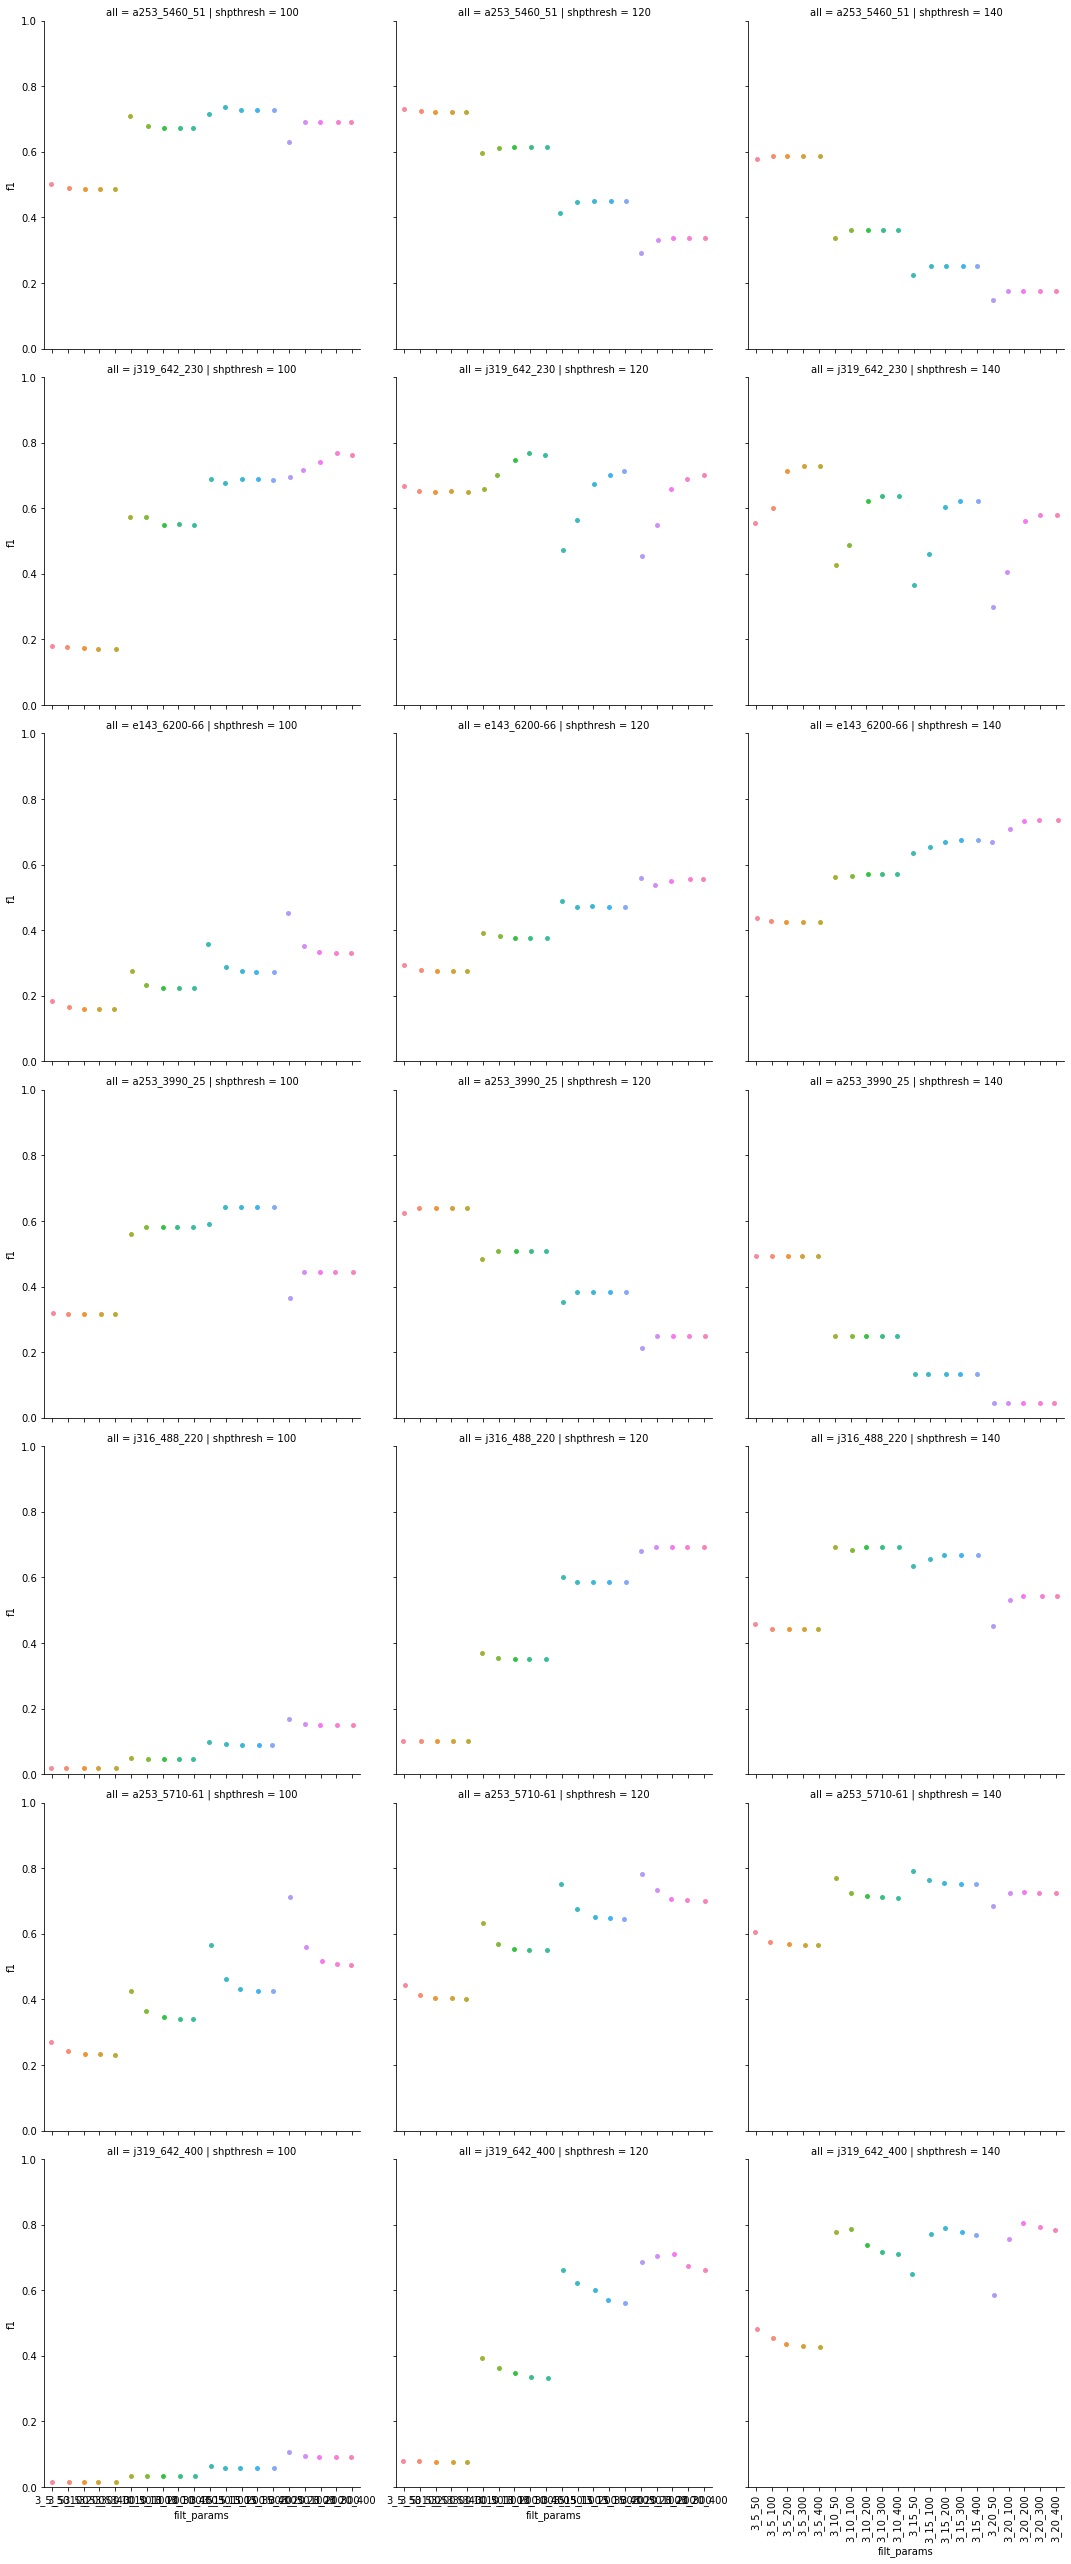

In [92]:
sns.catplot(data = pd_filt[pd_filt['bck']=='k9'],x='filt_params',y='f1',col='shpthresh',row = 'all')
plt.xticks(rotation=90)
plt.ylim([0,1])
plt.show()

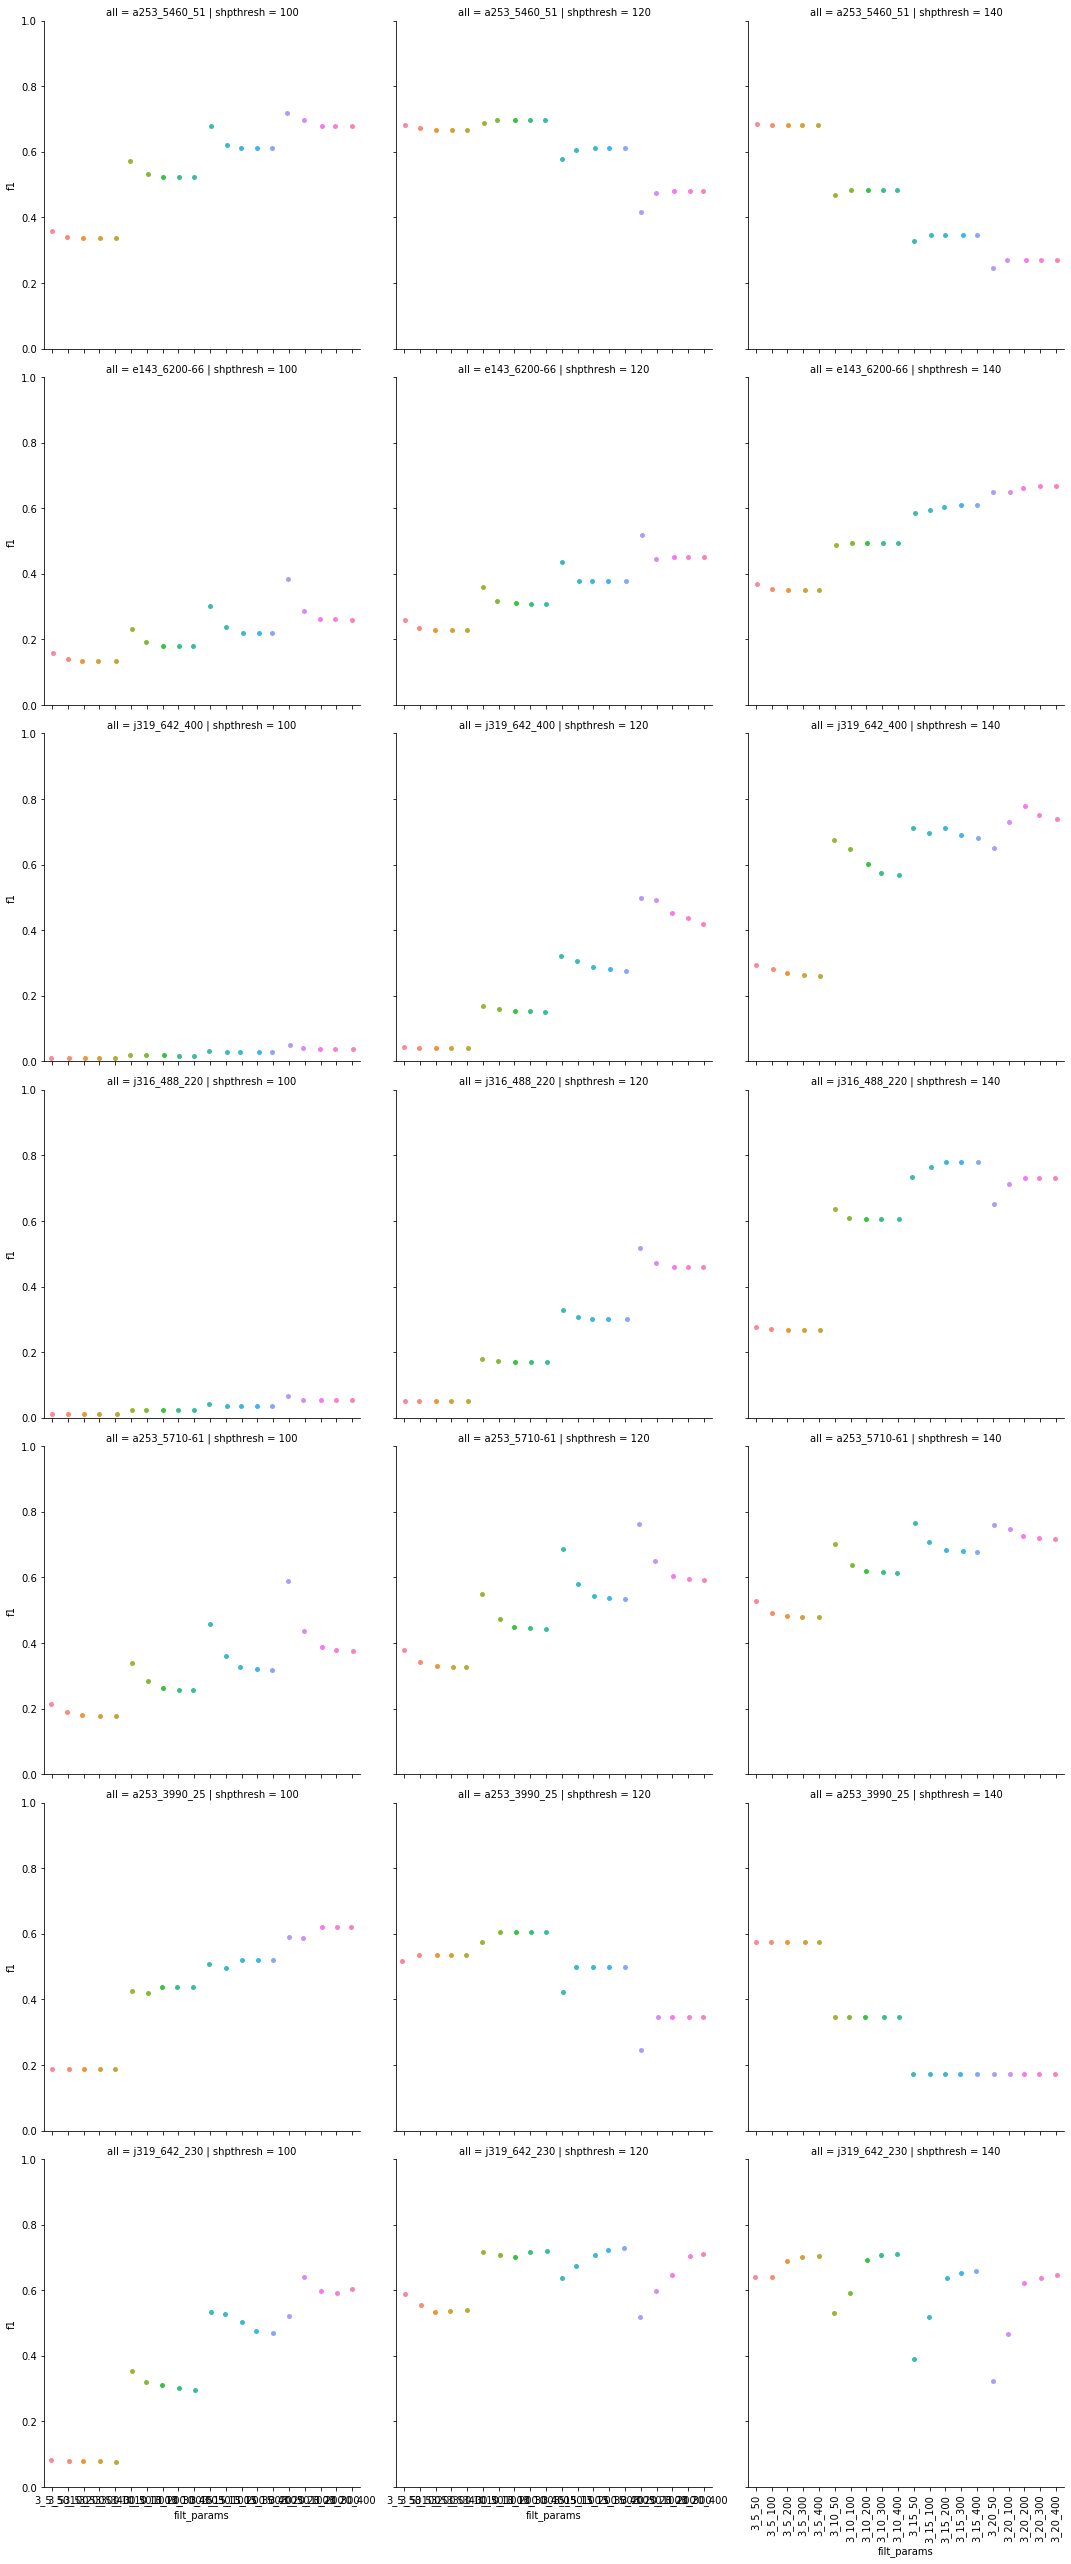

In [93]:
sns.catplot(data = pd_filt[pd_filt['bck']=='11'],x='filt_params',y='f1',col='shpthresh',row = 'all')
plt.xticks(rotation=90)
plt.ylim([0,1])

plt.show()

In [110]:
pd_filt.head()

,Unnamed: 0,all,bck,shpthresh,filt_params,tp,fp,fn,precision,recall,f1
0,0,a253_5710-61,k7,120,3_5_50,668,1202,0,0.357219,1.0,0.526399
1,1,a253_5710-61,k7,120,3_5_100,668,1326,0,0.335005,1.0,0.501878
2,2,a253_5710-61,k7,120,3_5_200,668,1354,0,0.330366,1.0,0.496654
3,3,a253_5710-61,k7,120,3_5_300,668,1360,0,0.329389,1.0,0.495549
4,4,a253_5710-61,k7,120,3_5_400,668,1361,0,0.329226,1.0,0.495365


In [117]:
pd_filt2=pd_filt[pd_filt['precision']>0.6]
tst = pd_filt2.groupby(['bck','shpthresh','filt_params']).mean()


Unnamed: 0          tp          fp         fn  \
bck shpthresh filt_params                                                   
11  100       3_20_100      116.000000  229.000000  131.000000  69.000000   
              3_20_200      117.000000  229.000000  147.000000  69.000000   
              3_20_300      118.000000  229.000000  147.000000  69.000000   
              3_20_400      119.000000  229.000000  148.000000  69.000000   
              3_20_50      1995.000000  116.000000   44.000000  54.000000   
...                                ...         ...         ...        ...   
k9  140       3_5_100      2234.333333   57.666667   10.000000  74.000000   
              3_5_200      2235.333333   60.333333   10.000000  71.333333   
              3_5_300      2236.333333   60.666667   10.000000  71.000000   
              3_5_400      2237.333333   60.666667   10.000000  71.000000   
              3_5_50       2233.333333   55.333333    8.333333  76.333333   

                           precision    recall        f1  
bck shpthresh filt_params                                 
11  100       3_20_100      0.636111  0.768456  0.696049  
              3_20_200      0.609043  0.768456  0.679525  
              3_20_300      0.609043  0.768456  0.679525  
              3_20_400      0.607427  0.768456  0.678519  
              3_20_50       0.687402  0.624481  0.653978  
...                              ...       ...       ...  
k9  140       3_5_100       0.813366  0.429216  0.559311  
              3_5_200       0.827541  0.477701  0.597406  
              3_5_300       0.828950  0.483762  0.601735  
              3_5_400       0.828950  0.483762  0.601735  
              3_5_50        0.833264  0.401618  0.541735  

[206 rows x 7 columns]

In [121]:
tst.to_csv('/home/emilyjanedennis/Desktop/tst.csv')